# Desne Vector Representations

___

## Word2Vec

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

# Importing the dataset
dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


## Preprocessing

In [2]:
# Clean erroneous class
dataset.iloc[97]["Final Status"] = "Positive"
dataset.iloc[97]["Final Status"]
# Convert to binary
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [3]:
negative_words = {
    "no",
    "not",
    "none",
    "neither",
    "never",
    "nobody",
    "nothing",
    "nowhere",
    "doesn't",
    "isn't",
    "wasn't",
    "shouldn't",
    "won't",
    "can't",
    "couldn't",
    "don't",
    "haven't",
    "hasn't",
    "hadn't",
    "aren't",
    "weren't",
    "wouldn't",
    "daren't",
    "needn't",
    "didn't",
    "without",
    "against",
    "negative",
    "deny",
    "reject",
    "refuse",
    "decline",
    "unhappy",
    "sad",
    "miserable",
    "hopeless",
    "worthless",
    "useless",
    "futile",
    "disagree",
    "oppose",
    "contrary",
    "contradict",
    "disapprove",
    "dissatisfied",
    "objection",
    "unsatisfactory",
    "unpleasant",
    "regret",
    "resent",
    "lament",
    "mourn",
    "grieve",
    "bemoan",
    "despise",
    "loathe",
    "detract",
    "abhor",
    "dread",
    "fear",
    "worry",
    "anxiety",
    "sorrow",
    "gloom",
    "melancholy",
    "dismay",
    "disheartened",
    "despair",
    "dislike",
    "aversion",
    "antipathy",
    "hate",
    "disdain",
}
sw = set(stopwords.words("english"))
stop_words = sw - negative_words

In [4]:
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    # text = re.sub("[^a-zA-Z0-9]", " ", str(text))  # also numbers
    # text = re.sub("[^a-zA-Z0-9%]", " ", str(text))  # also numbers and %
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]
    #tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

In [5]:
def tokenize_sentence(text):
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    # text = re.sub("[^a-zA-Z0-9]", " ", str(text))  # also numbers
    # text = re.sub("[^a-zA-Z0-9%]", " ", str(text))  # also numbers and %
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [6]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

for i in range(len(dataset["processed_article"])):
    dataset.loc[i, "processed_article"] = preprocess_text(
        dataset["processed_article"][i]
    )
    corpus.append(dataset["processed_article"][i])
print(len(corpus),corpus)

400 ['bank hold subsidi share say payment firm compani written nation payment corp india npci complain crore crore grant budget retain bank reuterspay compani bank loggerhead share govern grant subsidi build payment infrastructur said three peopl knowledg matter compani written nation payment corp india npci complain crore crore grant budget retain bank said depriv compani connect last mile state promis revenu accord govern grant subsidi exchang waiv merchant discount rate mdr charg govern releas crore worth subsidi bank not share payment aggreg said ceo payment compani condit anonym compens mdr waiver taken matter npci nodal agenc feedback got take matter respect bank not respond last year financ minist nirmala sitharaman announc rs crore fund hasten expans india digit payment industri move seen compens waiver mdr use unifi payment interfac upi rupay card previou budget payment aggreg entitl receiv basi point subvent small valu digit transact basi point percentag point ask bank proces

In [7]:
tokenized_corpus = [tokenize_sentence(article) for article in corpus]
print(len(tokenized_corpus),tokenized_corpus)

400 [['bank', 'hold', 'subsidi', 'share', 'say', 'payment', 'firm', 'compani', 'written', 'nation', 'payment', 'corp', 'india', 'npci', 'complain', 'crore', 'crore', 'grant', 'budget', 'retain', 'bank', 'reuterspay', 'compani', 'bank', 'loggerhead', 'share', 'govern', 'grant', 'subsidi', 'build', 'payment', 'infrastructur', 'said', 'three', 'peopl', 'knowledg', 'matter', 'compani', 'written', 'nation', 'payment', 'corp', 'india', 'npci', 'complain', 'crore', 'crore', 'grant', 'budget', 'retain', 'bank', 'said', 'depriv', 'compani', 'connect', 'last', 'mile', 'state', 'promi', 'revenu', 'accord', 'govern', 'grant', 'subsidi', 'exchang', 'waiv', 'merchant', 'discount', 'rate', 'mdr', 'charg', 'govern', 'relea', 'crore', 'worth', 'subsidi', 'bank', 'not', 'share', 'payment', 'aggreg', 'said', 'ceo', 'payment', 'compani', 'condit', 'anonym', 'compen', 'mdr', 'waiver', 'taken', 'matter', 'npci', 'nodal', 'agenc', 'feedback', 'got', 'take', 'matter', 'respect', 'bank', 'not', 'respond', 'las

## Vector Representations

In [8]:
# TODO: see best way to tune Word2Vec
# param_grid = {
#     "vector_size": [50, 100, 150],
#     "window": [3, 5, 7],
#     "min_count": [1, 2, 3],
#     'sg': [0, 1],
#     "epochs": [5, 10, 15],
# }

# best_score = -1
# best_params = {}

# for params in ParameterGrid(param_grid):
#     model = Word2Vec(sentences=tokenized_corpus, **params)
#     similarity = cosine_similarity([model.wv["good"]], [model.wv["great"]])[0][0]

#     if similarity > best_score:
#         best_score = similarity
#         best_params = params

# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

In [9]:
# Tuned model
# word2vec_model = Word2Vec(sentences=tokenized_corpus, **best_params)

word2vec_model = Word2Vec(sentences=tokenized_corpus)

In [10]:
X_word2vec = []
for article in tokenized_corpus:
    vectors = [
        word2vec_model.wv[word] for word in article if word in word2vec_model.wv
    ]
    if vectors:
        article_vector = np.mean(vectors, axis=0)
        X_word2vec.append(article_vector)
    else:
        X_word2vec.append(np.zeros(word2vec_model.vector_size))
print(X_word2vec)

[array([-0.12302455,  0.01025626,  0.41101155,  0.336647  , -0.1285138 ,
       -0.4865123 , -0.01683425,  0.25565594, -0.26976734, -0.15864566,
       -0.1304573 , -0.31602368, -0.14928503,  0.22442268, -0.07090226,
       -0.36856428,  0.02086409, -0.5084239 ,  0.04903244, -0.6279843 ,
        0.12037151,  0.14455517,  0.35460976, -0.03166166, -0.12566788,
       -0.10571259, -0.2176302 , -0.16389158,  0.12869243,  0.04421408,
        0.23576692,  0.14513272, -0.14543322,  0.12665829,  0.21113521,
       -0.08818636,  0.02626656, -0.44271743,  0.02955115, -0.3601191 ,
       -0.2971252 , -0.03476985,  0.06864791,  0.1738811 ,  0.21204795,
       -0.3613197 , -0.17721711, -0.10643963,  0.46459123,  0.19257797,
       -0.06859241, -0.2808581 , -0.22826758, -0.12513138, -0.28073317,
       -0.15478377, -0.09629104,  0.05899502, -0.15613063,  0.36763728,
        0.1351706 , -0.13784818,  0.05364254,  0.21015756, -0.2702085 ,
        0.103683  , -0.05153369, -0.04594677, -0.29190853,  0.3

In [11]:
X_word2vec = np.array(X_word2vec)
y = np.array(dataset["Final Status"])

## Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_word2vec, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(np.array(np.unique(y_train, return_counts=True)))

print("\nLabel distribution in the test set:")
print(np.array(np.unique(y_test, return_counts=True)))

(320, 100) (320,)
(80, 100) (80,)

Label distribution in the training set:
[[  0   1]
 [144 176]]

Label distribution in the test set:
[[ 0  1]
 [40 40]]


## Classifier Training

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [14]:
# Classifier Tuning
# TODO: check best way to tune in a pipeline

# classifier = RandomForestClassifier()

# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [None, 10, 20],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
# }


# grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
# grid_search.fit(X_train, y_train)
# y_pred = grid_search.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Classifier Accuracy:", accuracy)
# print("Best Parameters:", grid_search.best_params_)
# clf_best_params = grid_search.best_params_

In [15]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [16]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

## Evaluation

In [17]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers.items()
}

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


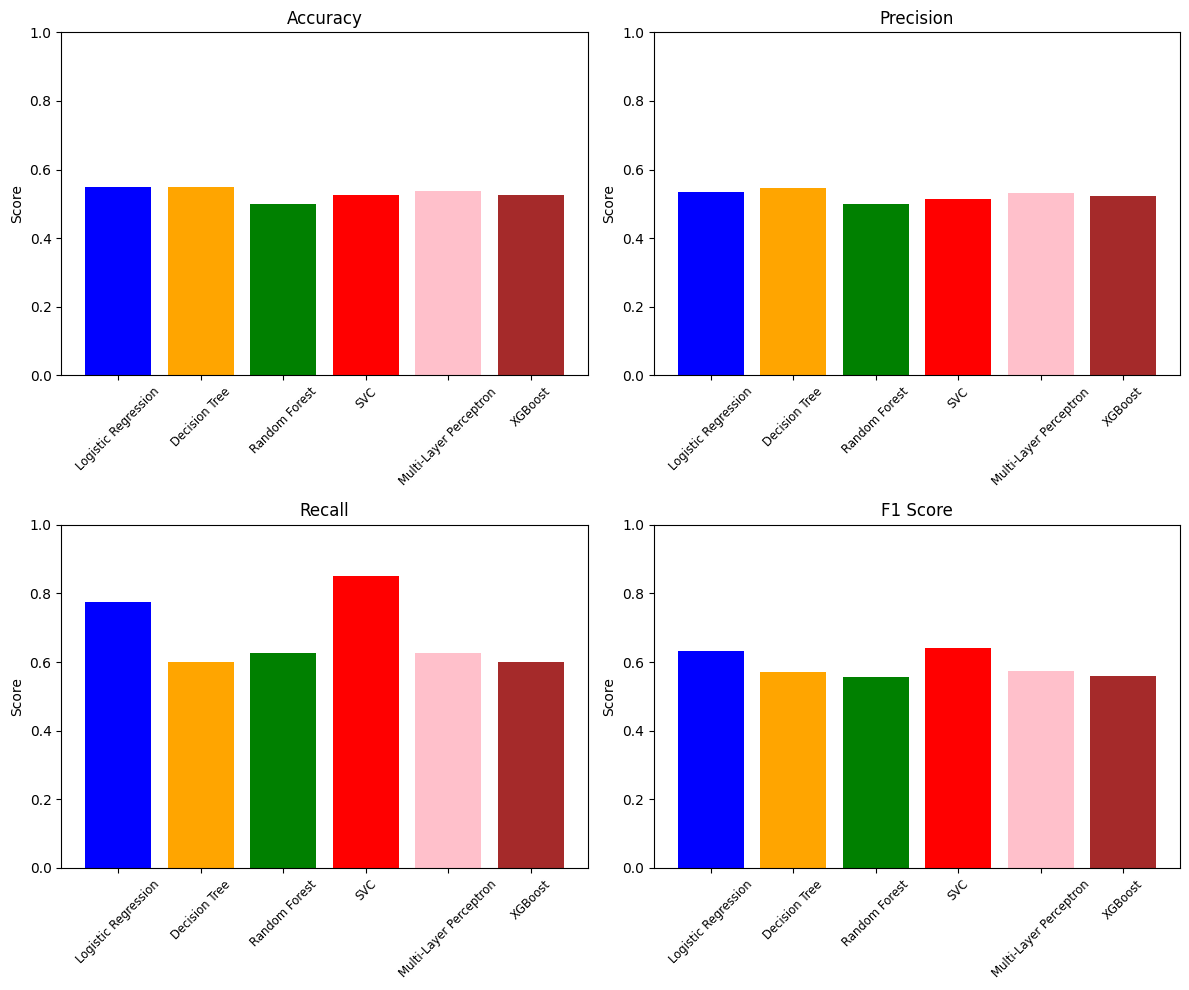

Classifier: Logistic Regression
Accuracy: 0.55
Precision: 0.53
Recall: 0.78
F1 Score: 0.63
------------------------------
Classifier: Decision Tree
Accuracy: 0.55
Precision: 0.55
Recall: 0.60
F1 Score: 0.57
------------------------------
Classifier: Random Forest
Accuracy: 0.50
Precision: 0.50
Recall: 0.62
F1 Score: 0.56
------------------------------
Classifier: SVC
Accuracy: 0.53
Precision: 0.52
Recall: 0.85
F1 Score: 0.64
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.54
Precision: 0.53
Recall: 0.62
F1 Score: 0.57
------------------------------
Classifier: XGBoost
Accuracy: 0.53
Precision: 0.52
Recall: 0.60
F1 Score: 0.56
------------------------------


In [18]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

## Cross Validation

In [19]:
# TODO: implement in pipeline
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(classifier, X_word2vec, y, cv=10)

# print(scores)
# print(
#     "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
# )

___

## FastText

## Vector Representations

In [20]:
# TODO: See best way to tune FastText

fasttext_model = FastText(sentences=tokenized_corpus)

In [21]:
X_fasttext = np.array(
    [
        np.mean(
            [fasttext_model.wv[word] for word in article if word in fasttext_model.wv],
            axis=0,
        )
        for sentence in tokenized_corpus
    ]
)

print(X_fasttext)

[[-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]
 [-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]
 [-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]
 ...
 [-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]
 [-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]
 [-0.18873589  0.10577166 -0.2605295  ... -0.3921838   0.10499267
   0.5759561 ]]


## Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fasttext,y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(np.array(np.unique(y_train, return_counts=True)))

print("\nLabel distribution in the test set:")
print(np.array(np.unique(y_test, return_counts=True)))

(320, 100) (320,)
(80, 100) (80,)

Label distribution in the training set:
[[  0   1]
 [144 176]]

Label distribution in the test set:
[[ 0  1]
 [40 40]]


## Evaluation

In [23]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers.items()
}

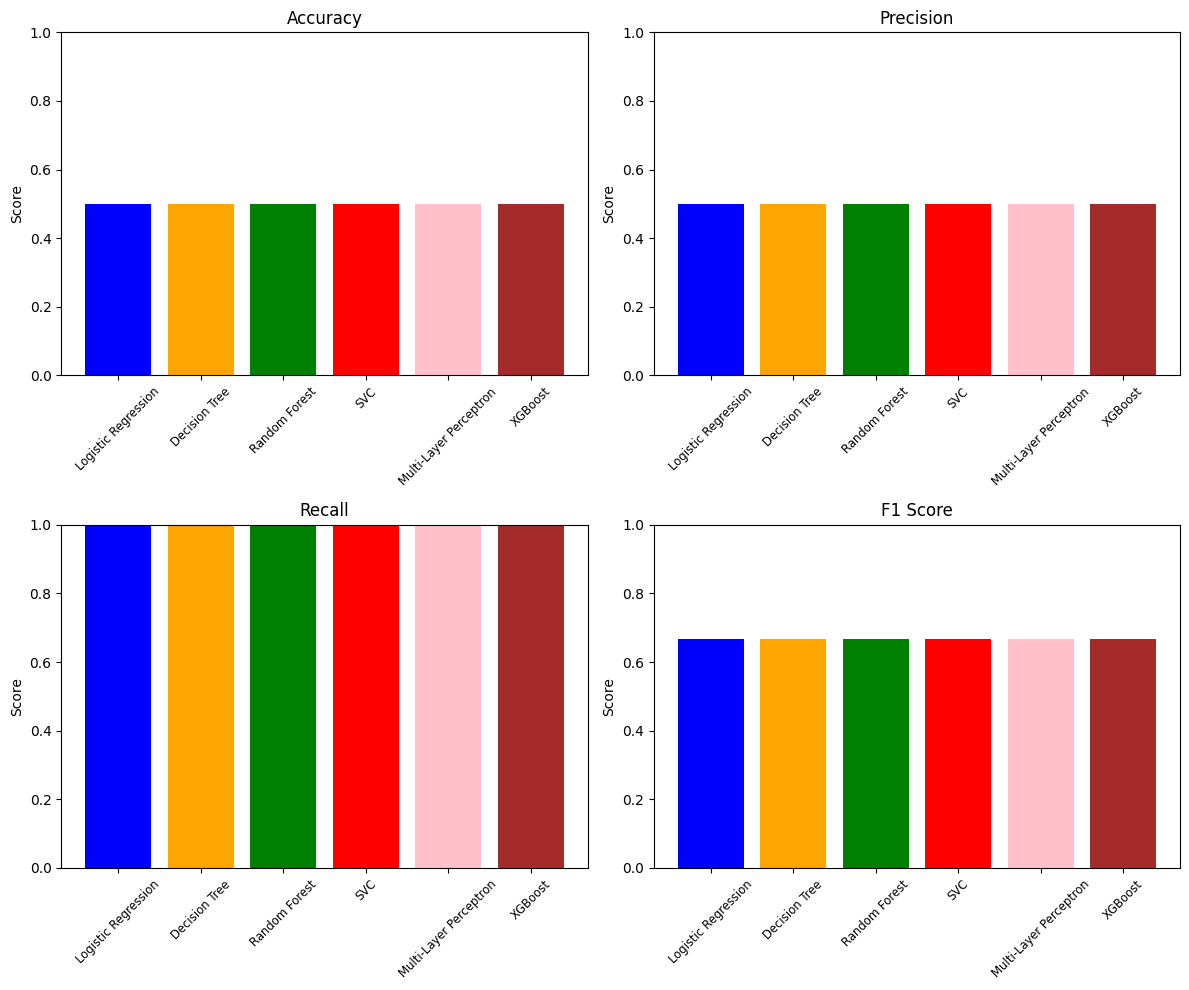

Classifier: Logistic Regression
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: Decision Tree
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: Random Forest
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: SVC
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: XGBoost
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------


In [24]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

## Cross Validation

In [25]:
# TODO: implement in pipeline
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(classifier, X_fasttext, y, cv=10)

# print(scores)

# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))